In [6]:
import copy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

import time
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

In [2]:
# @title Helper functions
def print_params(model):
  """
  Lists the name and current value of the model's
  named parameters

  Args:
    model: an nn.Module inherited model
      Represents the ML/DL model

  Returns:
    Nothing
  """
  for name, param in model.named_parameters():
    if param.requires_grad:
      print(name, param.data)# @title Helper functions

#### Set Seed

In [3]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call the `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules are used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


#### Download and transform data

In [11]:
train_set = datasets.MNIST(
    root='data/raw',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
test_set = datasets.MNIST(
    root="data/raw",
    train=True,
    download=False,
    transform=torchvision.transforms.ToTensor(),
)

# standardize data
mean = train_set.data.float().mean()
std = train_set.data.float().std()

manual_normalization = True
if manual_normalization:
    # manually
    train_set.data = (train_set.data - mean)/std
    test_set.data = (train_set.data - mean)/std
else:
    train_set = datasets.MNIST(
        root="data/raw",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081)
            )
        ])
    )

    test_set = datasets.MNIST(
        root="data/raw",
        train=False,
        download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081)
            )
        ])
    )



100%|██████████| 9.91M/9.91M [00:05<00:00, 1.74MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 334kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.85MB/s]


In [12]:
# sample random subset of 500 indices
subset_index = np.random.choice(len(train_set.data), 500)

# targets - y - are the labels
X, y = train_set.data[subset_index,:], train_set.targets[subset_index]

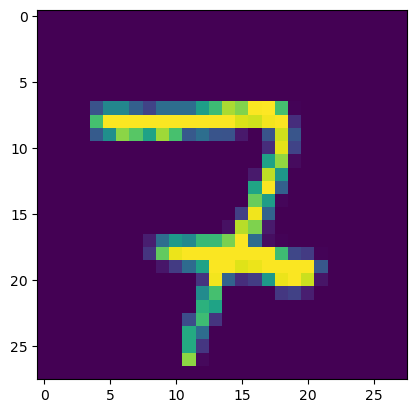

In [17]:
plt.imshow(X[0])

#### Create Multi-Layer Perceptron Model

In [43]:
class MLP(nn.Module):

    def __init__(self, in_dim = 784, out_dim = 10, hidden_dims = [], use_bias = True):
        """
        Constructs a Multilayer Perceptron
        Args:
          in_dim: dimensionality of input data
          out_dim: number of classes
          hidden_dims: contains dimensions of hidden layers

        Returns:
          Nothing

        """
        super(MLP, self).__init__() # makes MLP class inherit attributes from nn.Module

        self.in_dim = in_dim
        self.out_dim = out_dim

        if len(hidden_dims) == 0:
            layers = [nn.Linear(in_dim, out_dim, bias = use_bias)]
        else:
            layers = [nn.Linear(in_dim, hidden_dims[0], bias = use_bias), nn.ReLU()]

            for i, hidden_dim in enumerate(hidden_dims[:-1]):
                layers += [nn.Linear(hidden_dim, hidden_dim[i+1], bias = use_bias), nn.ReLU()]
                
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        # flatten images into a vector
        transformed_x = x.view(-1, self.in_dim)
        hidden_output = self.main(transformed_x)
        output = F.log_softmax(hidden_output, dim=1)
        return output


In [ ]:
model = MLP()

# negative loss likelihood - cross-entropy loss - an appropriate loss function for classification problems
# Why again?
loss_fn = F.nll_loss

# this is an alternative that produces the same results
#loss_fn = nn.CrossEntropyLoss()

model

MLP(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [45]:
def train(model, X: torch.Tensor, y: torch.Tensor, epochs = 200):

    loss_fn = F.nll_loss
    #loss_fn = nn.CrossEntropyLoss()


    print('Init Loss: ', loss_fn(model(X), y).item())

    learning_rate = 7e-4
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    for iepoch in range(epochs):
        loss = loss_fn(model(X), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('End Loss: ', loss_fn(model(X), y).item())

In [46]:
train(model, X=X, y=y)

Init Loss:  2.4030067920684814
End Loss:  0.10310503840446472


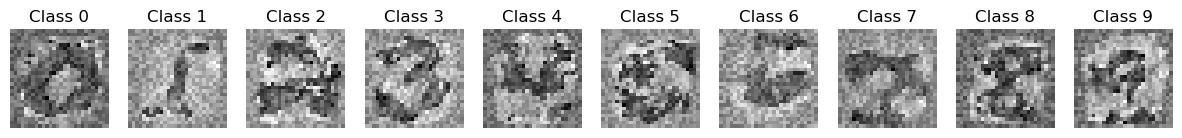

In [ ]:
# show class filters of trained model
W = model.main[0].weight.data.numpy()

fig, axs = plt.subplots(1, 10, figsize=(15, 4))
for class_id in range(10):
  axs[class_id].imshow(W[class_id, :].reshape(28, 28), cmap='gray_r')
  axs[class_id].axis('off')
  axs[class_id].set_title('Class ' + str(class_id) )

plt.show()

In [36]:
W.shape

(10, 784)

#### Implement Gradient Descent Manually

In [ ]:
def zero_grad(params):
    """
    This function does the same as optimizer.zero_grad() in torch library
    """

    for param in params:
        if not(param.grad is None): # there is a gradient value
            param.grad.data.zero()

def random_update(model, noise_scale, normalized = False):
    """
    Performs random update of parameters. Meant for comparison to gradient descent

    Args:
      model: nn.Module derived class
      noise_scale: specifies magnitude of random weight
      normalized: indicates if the parameter has been normalized or not

    Returns:
        Nothing
    """

    for par in model.parameters():
        noise = torch.randn_like(par)
        if normalized:
            noise /= torch.norm(noise)
        par.data += noise_scale*noise

In [108]:
# implement gradient descent

def gradient_update(loss, params, learning_rate = 1E-3):

    zero_grad(params)

    loss.backward()

    with torch.no_grad():
        for par in params:

            par.data -= learning_rate*par.grad.data

set_seed(seed=SEED)
model = MLP()
print(model)
print_params(model)

params_before_training = dict()

for name, param in model.named_parameters():
    if param.requires_grad:
      params_before_training[name] = param.data.detach().clone()
      
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(model(X), y)

Random seed 2021 has been set.
MLP(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)
main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])


In [109]:
gradient_update(loss=loss, params=list(model.parameters()), learning_rate=1e-1)
print_params(model=model)

main.0.weight tensor([[-0.0263,  0.0010,  0.0174,  ...,  0.0298,  0.0278, -0.0220],
        [-0.0047, -0.0302, -0.0093,  ..., -0.0077,  0.0248, -0.0240],
        [ 0.0234, -0.0237,  0.0335,  ...,  0.0117,  0.0263, -0.0187],
        ...,
        [-0.0006,  0.0156,  0.0110,  ...,  0.0143, -0.0302, -0.0145],
        [ 0.0164,  0.0286,  0.0238,  ..., -0.0127, -0.0191,  0.0188],
        [ 0.0206, -0.0354, -0.0184,  ..., -0.0272,  0.0098,  0.0002]])
main.0.bias tensor([-0.0292, -0.0018,  0.0115, -0.0370,  0.0054,  0.0155,  0.0317,  0.0246,
         0.0198, -0.0061])


In [110]:
params_after_training = dict()

for name, param in model.named_parameters():
    if param.requires_grad:
      params_after_training[name] = param.data

In [111]:
params_after_training['main.0.weight']

tensor([[-0.0263,  0.0010,  0.0174,  ...,  0.0298,  0.0278, -0.0220],
        [-0.0047, -0.0302, -0.0093,  ..., -0.0077,  0.0248, -0.0240],
        [ 0.0234, -0.0237,  0.0335,  ...,  0.0117,  0.0263, -0.0187],
        ...,
        [-0.0006,  0.0156,  0.0110,  ...,  0.0143, -0.0302, -0.0145],
        [ 0.0164,  0.0286,  0.0238,  ..., -0.0127, -0.0191,  0.0188],
        [ 0.0206, -0.0354, -0.0184,  ..., -0.0272,  0.0098,  0.0002]])

In [112]:
params_before_training['main.0.weight'] - params_after_training['main.0.weight']

tensor([[-6.9546e-05, -6.9545e-05, -6.9546e-05,  ..., -6.9546e-05,
         -6.9546e-05, -6.9546e-05],
        [ 6.6682e-04,  6.6682e-04,  6.6682e-04,  ...,  6.6682e-04,
          6.6682e-04,  6.6682e-04],
        [ 6.5921e-04,  6.5921e-04,  6.5921e-04,  ...,  6.5921e-04,
          6.5921e-04,  6.5921e-04],
        ...,
        [ 1.0257e-04,  1.0257e-04,  1.0257e-04,  ...,  1.0257e-04,
          1.0257e-04,  1.0257e-04],
        [ 1.6603e-03,  1.6603e-03,  1.6603e-03,  ...,  1.6603e-03,
          1.6603e-03,  1.6603e-03],
        [ 1.3766e-04,  1.3766e-04,  1.3766e-04,  ...,  1.3766e-04,
          1.3766e-04,  1.3766e-04]])

### Adaptive Gradient Descent

#### Standard gradient descent.
$$
[w_{t+1}] = [w_{t}]_{i} - \eta [\nabla J(w)]_{i}
$$

for parameter i at time step (epoch) t, where J is cost function to be minimized.

Written differently (the sum of deviations between targets - true data - and the model estimates is written out explicitly):

$$
[w_{t+1}] = [w_{t}]_{i} - \eta \frac{1}{N}\sum_{j}^{N}\nabla l(y_{j}, f_{w}(x_{i}))
$$

#### Stochastic gradient descent
Divide data into batches compute gradient for each seperately:

$$
[w_{t+1}] = [w_{t}]_{i} - \eta \frac{1}{|B_{t}|}\sum_{j}^{B_{t}}\nabla l(y_{j}, f_{w}(x_{i}))
$$

The subset (batch) B_{t} is different at each training step (epoch) t.

#### Poor Conditioning

When the loss landscape is steep in some directions and flat in others. A big learning rate gives you problems in the steep parts. A small learning rate is too slow for the flat parts.

#### Momentum

$$
[w_{t+1}] = [w_{t}]_{i} - \eta [\nabla J(w)]_{i} + \beta ([w_{t}]_{i} - [w_{t-1}]_{i})
$$

Difference between weights at previous time step included. This will dampen oscillation. If the difference between succesive w's is small (flat descent), bigger steps will be taken because they cancel other out. If the difference is big because the descent is steep, this extra term will shrink the step size and lessen the oscillation.

### Adaptive Methods

#### Adagrad

Idea: individual learning rates for different weights or layers. Adapts learning rate for each parameter.

$$
[w_{t+1}] = [w_{t}]_{i} - \frac{\eta}{\sqrt{v_{t+1}+\epsilon}} [\nabla J(w)]_{i}
$$

where

$$
v_{t+1} = \sum_{s}^{t} \nabla [J(w_{s})]^{2}_{i}
$$

A running sum of (squared) gradients in the denominator that the learning rate is divided by. You take all the previous gradients into account. Leads to a decay in learning rate as we go along. Works well on convex objectives.

#### RMS prop

Variant of Adagrad where we use a moving average instead of running sum. Will forget past gradients, so that can adapt to newer changes in landscape. Useful for non-convex objectives.

$$
[w_{t+1}] = [w_{t}]_{i} - \frac{\eta}{\sqrt{v_{t+1}+\epsilon}} [\nabla J(w)]_{i}
$$

where

$$
v_{t+1} = \alpha [v_{t}]_{i} + (1-\alpha) \nabla [J(w_{s})]^{2}_{i}
$$

#### ADAM

Adaptive momentum. RMS prop + momentum (+ couple more tricks). Most popular adaptive method in deep learning.



#### General

General advantage of adaptive methods: Take past values of functions gradient into account. Good when we look for **global minimum** rather than just local minimum.


